# Feature Exploration

Goal: investigate each of the relevant features and conduct tests for significance between the relevant groups.

This is the notebook for the data with a true source article.

In [ ]:
import pandas as pd
import os
import numpy as np
from dotenv import load_dotenv
import ast
import glob
import pingouin as pg

load_dotenv()

data_folder = os.getenv("DATA_FOLDER")

file_prefix = 'true_label_data'#data with a true source article

# Use glob to find all CSV files with the given filename start
file_list = glob.glob(f"{data_folder}/{file_prefix}*.csv")

# Read each file into a DataFrame and concatenate them into a single DataFrame
dataframes = [pd.read_csv(file, sep=";",index_col=0) for file in file_list]
df = pd.concat(dataframes, ignore_index=True)

seaborn_palette = "Blues" #true data is color-coded blue

Testing for faulty labels

In [3]:
faulty_labels = 0
def safe_literal_eval(x):
    global faulty_labels
    try:
        return ast.literal_eval(x)
    except:
        faulty_labels += 1

df['Labels'] = df['Labels'].apply(safe_literal_eval)
print(faulty_labels)

0


## Statistical Analysis of NewsGuard scores (before Transformation)

In [4]:
df = df[df['Category'] != 'Coul']

In [5]:
df.groupby('Category')['avg_score'].describe() 

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
True,97.0,85.844064,10.736738,35.00,86.500000,87.650000,90.900000,100.0
Misl,82.0,88.923210,10.147226,35.00,87.784722,91.152778,94.263393,100.0
True,443.0,89.592625,10.115085,21.25,87.650000,91.611111,94.704861,100.0


In [6]:
pg.normality(data=df, dv='avg_score', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
                y=df.loc[df['Category'] == 'True', 'avg_score'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,17188.0,less,0.219966,-0.053681,0.52684


Rerunning the analysis for only the non-NaN label values

In [7]:
df = df[df['Labels'].notna()]

In [8]:
df.groupby('Category')['avg_score'].describe() 

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
True,97.0,85.844064,10.736738,35.00,86.500000,87.650000,90.900000,100.0
Misl,82.0,88.923210,10.147226,35.00,87.784722,91.152778,94.263393,100.0
True,443.0,89.592625,10.115085,21.25,87.650000,91.611111,94.704861,100.0


In [9]:
pg.normality(data=df, dv='avg_score', group='Category') #not normally distributed
# pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
#                 y=df.loc[df['Category'] == 'True', 'avg_score'],
#                 alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,W,pval,normal
Category,,,
Misl,0.672936,3.186644e-12,False
True,0.651738,4.601441e-29,False
True,0.693544,6.277756e-13,False


In [10]:
# placeholder_ng_score = df['avg_score'].median()
# placeholder_ng_score

## Feature Extraction

This is the main function for extracting and calculating the features for analysis.

In [11]:
def retrieve_params(label_dict_list, positions=False, headlines=False):
    #create three distinct lists to control each parameter
    # if label_dict_list is empty return NaN
    if not label_dict_list:
        return np.nan
    article_stances = []
    article_ng_scores = []
    article_serp_positions = []
    
    for article in label_dict_list: #this is the search level; here we can retrieve SERP position and Newsguard score
        if not article: #catch empty entries
            continue
        if len(article['comparisons']) == 0:
               continue
        #retrieve variables
        serp_newsguard = article['serp_newsguard']
        serp_position = article['serp_position']

        #add to lists for decomposed calculation
        article_ng_scores.append(serp_newsguard)
        article_serp_positions.append(serp_position)

        article_stance = 0
        for claim_pair in article['comparisons']: #this is the "article level"; here we can retrieve relative claim position and the bool headline info
            relation = claim_pair['relation']

            if relation == 0: #skip calculation logic for unrelated claims
                continue

            try:
                #retrieve relative claim positions
                fm_claim_position = claim_pair['fm_claim_position']
                serp_claim_position = claim_pair['serp_claim_position']

                #retrieve headline bool
                fm_claim_headline = claim_pair['fm_claim_headline']
                serp_claim_headline = claim_pair['serp_claim_headline']

            except:
                pass

            if not positions and not headlines: #calculate article stance only based on relation
                article_stance += relation
            if positions and not headlines: #calculate article stance based on relation and position
                if relation in [-1, 1]:
                    if serp_claim_position < fm_claim_position: #if serp claim earlier in the article than the respective fm claim
                        article_stance += relation + (serp_claim_position - fm_claim_position) if relation == -1 else relation - (serp_claim_position - fm_claim_position) #e.g. -1 - dif else 1 + dif (reinforcing in each direction)
                    else: # if serp claim later in article than the respective fm claim
                        article_stance += relation - (fm_claim_position - serp_claim_position) if relation == -1 else relation + (fm_claim_position - serp_claim_position) #e.g. - 1 + dif else 1 - dif (weakening in each direction)
            if positions and headlines:
                if relation in [-1, 1]:
                    individual_stance = 0
                    if serp_claim_position < fm_claim_position: #if serp claim earlier in the article than the respective fm claim
                        individual_stance = relation + (serp_claim_position - fm_claim_position) if relation == -1 else relation - (serp_claim_position - fm_claim_position) #e.g. -1 - dif else 1 + dif (reinforcing in each direction)
                        if serp_claim_headline:
                            individual_stance *= 2
                    else: # if serp claim later in article than the respective fm claim
                        individual_stance = relation - (fm_claim_position - serp_claim_position) if relation == -1 else relation + (fm_claim_position - serp_claim_position) #e.g. - 1 + dif else 1 - dif (weakening in each direction)
                        if serp_claim_headline:
                                individual_stance *= 2
                    article_stance += individual_stance
            if headlines and not positions:
                article_stance += relation * serp_claim_headline 
        if headlines and not positions:
            article_stances.append(article_stance/len(article['comparisons']))
        else:
            article_stances.append(article_stance/len(article['comparisons']))

    #if article_stances could not be successfully retrieved, return NaN
    if not article_stances:
        return np.nan
    
    article_ng_scores = np.array(article_ng_scores, dtype=float)
    # article_ng_scores = np.nan_to_num(article_ng_scores, nan=placeholder_ng_score) 

    return {'article_stances': article_stances, 'article_ng_scores': article_ng_scores, 'article_serp_positions': article_serp_positions}

Extracting the features based on different configs

In [12]:
df['Features_Raw']= df['Labels'].apply(retrieve_params)
df['Features_Pos']= df['Labels'].apply(lambda x: retrieve_params(x, positions=True, headlines=False))
df['Features_H']= df['Labels'].apply(lambda x: retrieve_params(x, positions=False, headlines=True))
df['Features_HP']= df['Labels'].apply(lambda x: retrieve_params(x, positions=True, headlines=True))

In [13]:
df = df[df['Features_Raw'].notna()]

In [14]:
df

,Article_day,ResponseId,Day,Category,True_Dummy,Seven_Ordinal,Four_Ordinal,Age,Gender,FC_Eval,...,avg_score,list_domains,list_scores,all_clean_urls,newsguard_dict,Labels,Features_Raw,Features_Pos,Features_H,Features_HP
0,Day_1_4,R_2y8dRM3TUWjSPIo,Day_1,Misl,0,1,1,20,0,True,...,92.750000,"factcheck.org', 'thehill.com', 'newsweek.com',...","100,80,100,100,90,92.5,95,87.5,87.5,95",('https://www.factcheck.org/2021/07/debunking-...,"{'factcheck.org': 100, 'thehill.com': 80, 'new...","[{}, {}, {}, {'comparisons': [{'claim_article_...","{'article_stances': [-0.04, -0.28, 0.08, -0.16...","{'article_stances': [-0.044121212121212124, -0...","{'article_stances': [0.0, 0.0, 0.0, 0.0, 0.0, ...","{'article_stances': [-0.044121212121212124, -0..."
1,Day_1_4,R_bqJ3HoBP0lqi7CN,Day_1,True,1,5,3,30,0,True,...,94.642857,"recorder.maricopa.gov', ''', 'azcentral.com', ...","92.5,100,87.5,95,95,92.5,100",('https://recorder.maricopa.gov/electionresult...,{},"[{}, {}, {'comparisons': [{'claim_article_a': ...","{'article_stances': [-0.2, -0.12, 0.04, 0.0, -...","{'article_stances': [-0.05843137254901954, -0....","{'article_stances': [0.0, 0.0, 0.0, 0.0, 0.0],...","{'article_stances': [-0.05843137254901954, -0...."
2,Day_1_4,R_5ovNt0RyjDe4zhD,Day_1,True,1,5,3,37,1,True,...,95.833333,"azcentral.com', 'abc15.com', 'thehill.com', 'p...","92.5,100,80,100,95,95,100,100,100",('https://www.azcentral.com/story/opinion/op-e...,"{'azcentral.com': 92.5, 'abc15.com': 100, 'the...","[{'comparisons': [{'claim_article_a': ""The lio...","{'article_stances': [0.08, 0.08, -0.08, 0.04, ...","{'article_stances': [0.1340952380952381, 0.060...","{'article_stances': [0.0, 0.0, 0.0, 0.0, 0.0],...","{'article_stances': [0.1340952380952381, 0.060..."
3,Day_1_4,R_1ILDrpPAAn0CdBx,Day_1,True,1,7,4,45,1,True,...,84.611111,"thehill.com', 'azcentral.com', 'abc15.com', 'w...","80,92.5,100,42,100,95,100,57,95",('https://thehill.com/homenews/campaign/563658...,"{'thehill.com': 80, 'azcentral.com': 92.5, 'ab...","[{}, {'comparisons': [{'claim_article_a': ""The...","{'article_stances': [0.08, 0.08, 0.0, 0.04], '...","{'article_stances': [0.1340952380952381, 0.060...","{'article_stances': [0.0, 0.0, 0.0, 0.0], 'art...","{'article_stances': [0.1340952380952381, 0.060..."
4,Day_1_4,R_3MycWKTJGEI3fkc,Day_1,True,1,7,4,44,1,True,...,95.833333,"azcentral.com', 'thehill.com', 'abc15.com', 'b...","92.5,80,100,95,100,95,100,100,100",('https://www.azcentral.com/story/opinion/op-e...,"{'azcentral.com': 92.5, 'thehill.com': 80, 'ab...","[{'comparisons': [{'claim_article_a': ""The lio...","{'article_stances': [0.08, 0.08, 0.0, -0.04, 0...","{'article_stances': [0.1340952380952381, 0.060...","{'article_stances': [0.0, 0.0, 0.0, 0.0, 0.0, ...","{'article_stances': [0.1340952380952381, 0.060..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,Day_12_4,R_2tsyqOCvwSnvYGB,Day_12,True,1,6,4,41,1,True,...,87.375000,"foxnews.com', 'usatoday.com', 'suffolk.edu', '...","69.5,100,100,100,92.5,87.5,69.5,80",('https://www.foxnews.com/politics/biden-appro...,"{'foxnews.com': 69.5, 'usatoday.com': 100, 'su...",[{'comparisons': [{'claim_article_a': 'Preside...,"{'article_stances': [0.52, 0.4, 0.48, 0.52, 0....","{'article_stances': [0.4066666666666666, 0.349...","{'article_stances': [0.0, 0.0, 0.0, 0.0, 0.0, ...","{'article_stances': [0.4066666666666666, 0.349..."
612,Day_12_4,R_3lskovMBpQinjLr,Day_12,True,1,6,3,36,0,True,...,85.550000,"usatoday.com', 'cnn.com', 'foxnews.com', 'nyti...","100,87.5,69.5,100,69.5,77,100,69.5,87.5,95",('https://www.usatoday.com/story/news/politics...,"{'usatoday.com': 100, 'cnn.com': 87.5, 'foxnew...",[{'comparisons': [{'claim_article_a': 'Preside...,"{'article_stances': [0.52, 0.0, 0.28, 0.56, 0....","{'article_stances': [0.45515789473684215, 0.0,...","{'article_stances': [0.0, 0.0, 0.0, 0.0, 0.0, ...","{'article_stances': [0.45515789473684215, 0.0,..."
613,Day_12_4,R_3h3c8lR9Ul1nE30,Day_12,True,1,5,3,32,1,True,...,85.850000,"cnn.com', 'usatoday.

# Additional Features for Exploration

## Label Transformation

In [15]:
label_mapping = {
    'Coul' : np.nan,
    'Misl' : 0,
    'True' : 1
}

df['User_Labels'] = df['Category'].map(label_mapping)

In [16]:
df = df[df['User_Labels'].notna()] #remove 'could' values

## Number of articles

In [17]:
def get_num_articles(label_lists):
    return sum(bool(d) for d in label_lists)

df['num_valid_articles'] = df['Labels'].apply(get_num_articles)

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\401153082.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_valid_articles'] = df['Labels'].apply(get_num_articles)


In [18]:
df['num_valid_articles'].describe()

count    474.000000
mean       5.362869
std        2.093777
min        1.000000
25%        4.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: num_valid_articles, dtype: float64

In [19]:
df.groupby('Category')['num_valid_articles'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,74.0,5.081081,2.124590,1.0,3.0,5.0,7.0,9.0
True,400.0,5.415000,2.086542,1.0,4.0,6.0,7.0,10.0


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\284188435.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, x='Value', y='Count', palette=seaborn_palette)


Text(0, 0.5, 'Frequency')

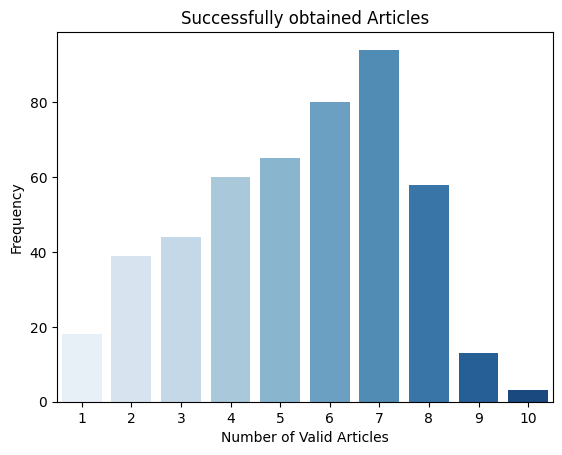

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = df['num_valid_articles'].value_counts().reset_index()
counts.columns = ['Value', 'Count']  # Rename columns for clarity

# Create the barplot
sns.barplot(data=counts, x='Value', y='Count', palette=seaborn_palette)
plt.title('Successfully obtained Articles')
plt.xlabel('Number of Valid Articles')
plt.ylabel('Frequency')

# Article Stances

## Raw Stances

In [21]:
#try different transformation methods

def transform_stances(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    stance_list = feat_dict['article_stances']
    return method(stance_list)

### Mean

In [22]:
df['Stances_Mean'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\1622541352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_Mean'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.mean))


In [23]:
df['Stances_Mean'].describe()

count    474.000000
mean       0.261906
std        0.201794
min       -0.400000
25%        0.100000
50%        0.261429
75%        0.435938
max        0.733333
Name: Stances_Mean, dtype: float64

In [24]:
df.groupby('Category')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,74.0,0.164059,0.193629,-0.4,0.001429,0.125714,0.316667,0.586667
True,400.0,0.280008,0.198267,-0.4,0.120000,0.289444,0.444667,0.733333


In [25]:
import pingouin as pg
pg.normality(data=df, dv='Stances_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_Mean'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is less than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,9819.5,less,0.000002,-0.33652,0.66826


In [26]:
df.groupby('num_valid_articles')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,18.0,0.177778,0.315027,-0.400000,0.000000,0.200000,0.430000,0.600000
2,39.0,0.329673,0.192495,0.000000,0.190000,0.400000,0.480000,0.640000
3,44.0,0.277116,0.234200,-0.080000,0.090000,0.253333,0.520000,0.733333
4,60.0,0.245885,0.252677,-0.380000,0.050000,0.255000,0.450000,0.630000
5,65.0,0.253317,0.193865,-0.088000,0.128000,0.224000,0.460000,0.576000
6,80.0,0.241410,0.170807,-0.106667,0.120000,0.250000,0.388580,0.600000
7,94.0,0.256708,0.181322,-0.125714,0.116429,0.254709,0.426071,0.566561
8,58.0,0.280656,0.162728,-0.070000,0.115000,0.292870,0.385000,0.670000
9,13.0,0.276239,0.143396,0.008889,0.217778,0.288889,0.351111,0.475556


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\3906879507.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Mean', palette=seaborn_palette)


Text(0, 0.5, 'Stances Mean')

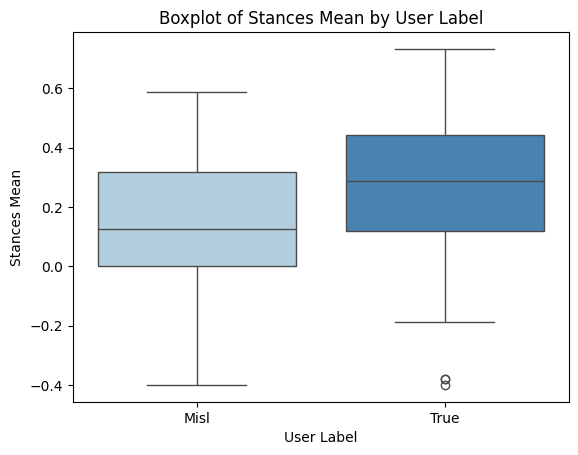

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='Category', y='Stances_Mean', palette=seaborn_palette)
plt.title('Boxplot of Stances Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\177119608.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='num_valid_articles', y='Stances_Mean', palette=seaborn_palette)


Text(0, 0.5, 'Stances Mean')

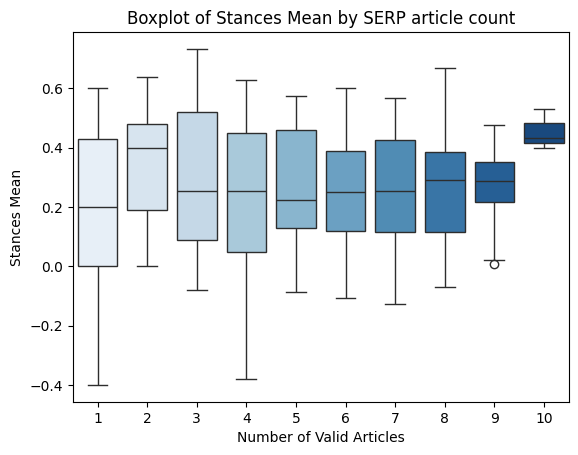

In [28]:
sns.boxplot(data=df, x='num_valid_articles', y='Stances_Mean', palette=seaborn_palette)
plt.title('Boxplot of Stances Mean by SERP article count')
plt.xlabel('Number of Valid Articles')
plt.ylabel('Stances Mean')

#### Last User Queries

In [29]:
last_search_df = df.drop_duplicates(subset='ResponseId', keep='last')
last_search_df.groupby('Category')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,25.0,0.169752,0.176533,-0.10,0.026667,0.125714,0.300000,0.525000
True,199.0,0.280353,0.191281,-0.38,0.143333,0.262857,0.447333,0.733333


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\1437997146.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=last_search_df, x='Category', y='Stances_Mean', palette=seaborn_palette)


Text(0, 0.5, 'Stances Mean')

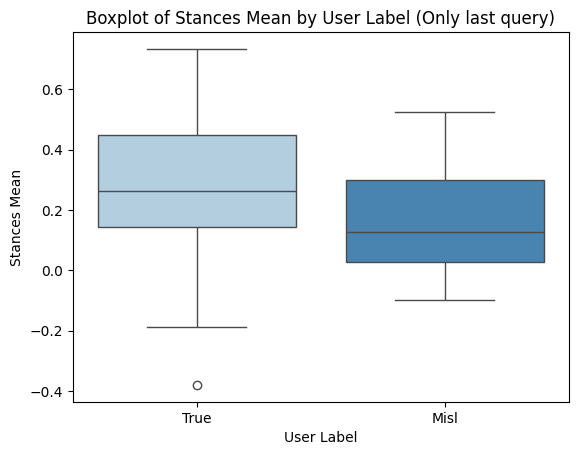

In [30]:
sns.boxplot(data=last_search_df, x='Category', y='Stances_Mean', palette=seaborn_palette)
plt.title('Boxplot of Stances Mean by User Label (Only last query)')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### NDCG

In [31]:
from sklearn.metrics import ndcg_score

In [32]:
test_array = [0.5, 0.01, 0.3, -1, 1]

#transform values to fit between 0 and 1

def ndcg(stances):
    stances = np.array(stances)
    stances = (stances + 1) / 2  # Transform values from [-1, 1] to [0, 1]
    if len(stances) == 1:
        return np.nan
    true_relevance = np.array([stances])  
    relevance_score = np.array([sorted(stances, reverse=True)]) 
    print(true_relevance, relevance_score)

    return ndcg_score(true_relevance, relevance_score)
          
ndcg(test_array)

[[0.75  0.505 0.65  0.    1.   ]] [[1.    0.75  0.65  0.505 0.   ]]


np.float64(0.883307074205988)

In [33]:
df['Stances_NDCG'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=ndcg))

[[0.48 0.36 0.54 0.42 0.52 0.48]] [[0.54 0.52 0.48 0.48 0.42 0.36]]
[[0.4  0.44 0.52 0.5  0.42]] [[0.52 0.5  0.44 0.42 0.4 ]]
[[0.54 0.54 0.46 0.52 0.48]] [[0.54 0.54 0.52 0.48 0.46]]
[[0.54 0.54 0.5  0.52]] [[0.54 0.54 0.52 0.5 ]]
[[0.54 0.54 0.5  0.48 0.52 0.38 0.54]] [[0.54 0.54 0.54 0.52 0.5  0.48 0.38]]
[[0.54 0.54 0.6 ]] [[0.6  0.54 0.54]]
[[0.5  0.54 0.44 0.58]] [[0.58 0.54 0.5  0.44]]
[[0.54 0.54 0.42 0.52 0.5  0.36]] [[0.54 0.54 0.52 0.5  0.42 0.36]]
[[0.54 0.58 0.52 0.5  0.44 0.42]] [[0.58 0.54 0.52 0.5  0.44 0.42]]
[[0.5 0.5 0.5 0.5]] [[0.5 0.5 0.5 0.5]]
[[0.52 0.5 ]] [[0.52 0.5 ]]
[[0.54 0.54 0.6 ]] [[0.6  0.54 0.54]]
[[0.6  0.5  0.58]] [[0.6  0.58 0.5 ]]
[[0.4  0.5  0.52 0.44 0.48 0.5  0.52]] [[0.52 0.52 0.5  0.5  0.48 0.44 0.4 ]]
[[0.54 0.54 0.34 0.56]] [[0.56 0.54 0.54 0.34]]
[[0.54 0.5  0.52 0.52 0.42]] [[0.54 0.52 0.52 0.5  0.42]]
[[0.54 0.5  0.7  0.56 0.38 0.38]] [[0.7  0.56 0.54 0.5  0.38 0.38]]
[[0.5  0.44 0.48 0.54 0.52 0.52 0.52]] [[0.54 0.52 0.52 0.52 0.5  0.48 0

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\1914666279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_NDCG'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=ndcg))


In [34]:
df['Stances_NDCG'].describe()

count    456.000000
mean       0.960736
std        0.034855
min        0.745418
25%        0.943129
50%        0.965241
75%        0.987811
max        1.000000
Name: Stances_NDCG, dtype: float64

In [35]:
df.groupby('Category')['Stances_NDCG'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,70.0,0.959544,0.039809,0.826093,0.943218,0.964823,0.988265,1.0
True,386.0,0.960952,0.033933,0.745418,0.943222,0.965276,0.987720,1.0


In [36]:
df.groupby('num_valid_articles')['Stances_NDCG'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39.0,0.980700,0.033867,0.859719,0.972491,1.000000,1.000000,1.000000
3,44.0,0.976619,0.030041,0.868115,0.972459,0.984740,1.000000,1.000000
4,60.0,0.962145,0.034150,0.863535,0.940694,0.971445,0.988751,1.000000
5,65.0,0.962944,0.040516,0.745418,0.943703,0.975750,0.989067,1.000000
6,80.0,0.959116,0.032461,0.801103,0.947040,0.964659,0.981445,0.998908
7,94.0,0.950232,0.035982,0.826093,0.933645,0.956764,0.976518,1.000000
8,58.0,0.954075,0.025151,0.844099,0.945367,0.959866,0.965097,1.000000
9,13.0,0.947915,0.034070,0.890233,0.925320,0.952583,0.978837,0.988966


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\876285696.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='num_valid_articles', y='Stances_NDCG', palette=seaborn_palette)


Text(0, 0.5, 'Stances Mean')

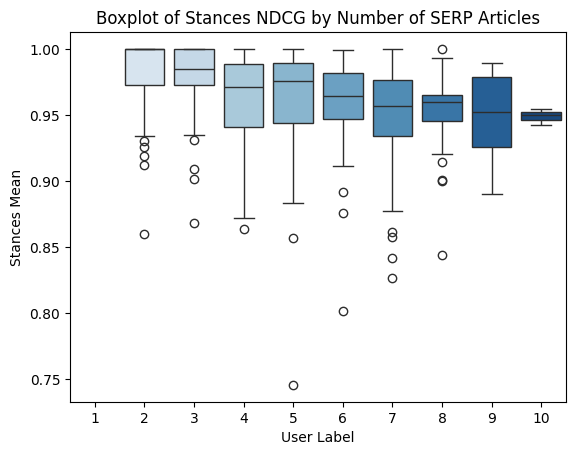

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='num_valid_articles', y='Stances_NDCG', palette=seaborn_palette)
plt.title('Boxplot of Stances NDCG by Number of SERP Articles')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### First vs. Last SERP Position

In [38]:
def retrieve_serp_results(feat_dict, position=1):
    if pd.isna(feat_dict):
        return np.nan
    
    stance_list = feat_dict['article_stances']
    serp_positions = feat_dict['article_serp_positions']
    
    if isinstance(position, list):
        results = [np.mean(stance_list[serp_positions.index(pos)]) for pos in position if pos in serp_positions]
        return np.nan if not results else np.mean(results)
    elif position in serp_positions:
        return np.mean(stance_list[serp_positions.index(position)])
    
    return np.nan

In [39]:
df['Stances_First'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[1]))
df['Stances_Last'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[10]))

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\2326893941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_First'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[1]))
C:\Users\danie\AppData\Local\Temp\ipykernel_11368\2326893941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_Last'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[10]))


In [40]:
df['Stances_First'].describe()

count    257.000000
mean       0.244647
std        0.246391
min       -1.000000
25%        0.080000
50%        0.280000
75%        0.400000
max        1.000000
Name: Stances_First, dtype: float64

In [41]:
df['Stances_Last'].describe()

count    229.000000
mean       0.242052
std        0.274279
min       -0.600000
25%        0.000000
50%        0.200000
75%        0.440000
max        1.000000
Name: Stances_Last, dtype: float64

In [42]:
pg.normality(data=df['Stances_First']) #not normally distributed
# pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
#                 y=df.loc[df['Category'] == 'True', 'avg_score'],
#                 alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,W,pval,normal
Stances_First,0.969339,0.000025,False


In [43]:
pg.normality(data=df['Stances_Last']) #not normally distributed

,W,pval,normal
Stances_Last,0.977072,0.000896,False


In [44]:
#comparing last vs first against each other (not considering category)

In [45]:
pg.mwu(x=df['Stances_First'],
        y=df['Stances_Last'],
        alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,30377.0,greater,0.268885,0.032301,0.51615


In [46]:
df.groupby('Category')['Stances_First'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,39.0,0.172308,0.275016,-0.52,0.00,0.12,0.4,0.6
True,218.0,0.257588,0.239303,-1.00,0.08,0.28,0.4,1.0


In [47]:
pg.normality(data=df, dv='Stances_First', group='Category') #not normally distributed
# pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_First'],
#                 y=df.loc[df['Category'] == 'True', 'Stances_First'],
#                 alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,W,pval,normal
Category,,,
Misl,0.958923,0.164148,True
True,0.962797,0.000018,False


In [48]:
df.groupby('Category')['Stances_Last'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,36.0,0.156667,0.233116,-0.2,0.0,0.14,0.24,0.6
True,193.0,0.257978,0.278938,-0.6,0.0,0.24,0.48,1.0


In [49]:
pg.normality(data=df, dv='Stances_Last', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_Last'],
                y=df.loc[df['Category'] == 'True', 'Stances_Last'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,2661.5,less,0.012761,-0.23388,0.61694


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\4087716365.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_First', palette=seaborn_palette)


Text(0, 0.5, 'Stances Mean')

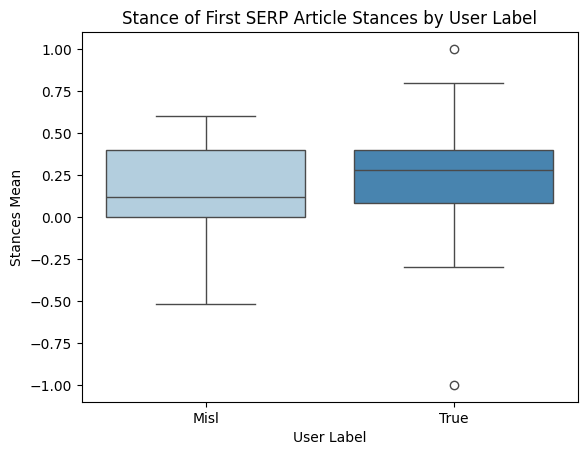

In [50]:
sns.boxplot(data=df, x='Category', y='Stances_First', palette=seaborn_palette)
plt.title('Stance of First SERP Article Stances by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

In [51]:
df['Stances_First'].describe()

count    257.000000
mean       0.244647
std        0.246391
min       -1.000000
25%        0.080000
50%        0.280000
75%        0.400000
max        1.000000
Name: Stances_First, dtype: float64

In [52]:
df['Stances_Last'].describe()

count    229.000000
mean       0.242052
std        0.274279
min       -0.600000
25%        0.000000
50%        0.200000
75%        0.440000
max        1.000000
Name: Stances_Last, dtype: float64

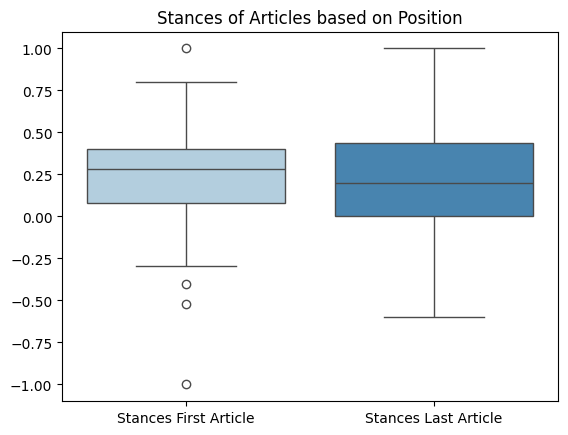

In [53]:
sns.boxplot(data=[df['Stances_First'], df['Stances_Last']], palette=seaborn_palette)
plt.title('Stances of Articles based on Position')
plt.xticks([0, 1], ['Stances First Article', 'Stances Last Article'])
plt.show()

In [54]:
df.groupby('Category')['Stances_Last'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,36.0,0.156667,0.233116,-0.2,0.0,0.14,0.24,0.6
True,193.0,0.257978,0.278938,-0.6,0.0,0.24,0.48,1.0


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\3757660247.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Last', palette=seaborn_palette)


Text(0, 0.5, 'Stances Mean')

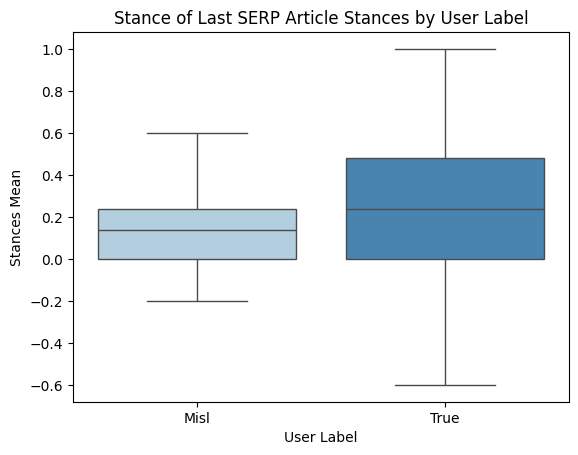

In [55]:
sns.boxplot(data=df, x='Category', y='Stances_Last', palette=seaborn_palette)
plt.title('Stance of Last SERP Article Stances by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### Median

In [56]:
df['Stances_Median'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.median))

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\614005084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_Median'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.median))


In [57]:
df['Stances_Median'].describe()

count    474.000000
mean       0.277357
std        0.211386
min       -0.400000
25%        0.120000
50%        0.280000
75%        0.440000
max        1.000000
Name: Stances_Median, dtype: float64

In [58]:
df.groupby('Category')['Stances_Median'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,74.0,0.186667,0.202877,-0.4,0.00,0.16,0.36,0.6
True,400.0,0.294135,0.208886,-0.4,0.16,0.28,0.46,1.0


In [59]:
df.groupby('num_valid_articles')['Stances_Median'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,18.0,0.177778,0.315027,-0.40,0.000000,0.200000,0.430,0.600
2,39.0,0.329673,0.192495,0.00,0.190000,0.400000,0.480,0.640
3,44.0,0.317273,0.279203,-0.12,0.080000,0.306667,0.520,1.000
4,60.0,0.258037,0.257297,-0.40,0.055000,0.278621,0.485,0.645
5,65.0,0.269231,0.211219,-0.20,0.160000,0.200000,0.480,0.600
6,80.0,0.255870,0.172560,-0.12,0.133333,0.240000,0.420,0.600
7,94.0,0.275020,0.185257,-0.12,0.160000,0.280000,0.400,0.600
8,58.0,0.294419,0.165969,-0.04,0.165000,0.293333,0.400,0.640
9,13.0,0.280000,0.143295,0.00,0.200000,0.320000,0.360,0.480


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\3584357433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Median', palette=seaborn_palette)


Text(0, 0.5, 'Stances Median')

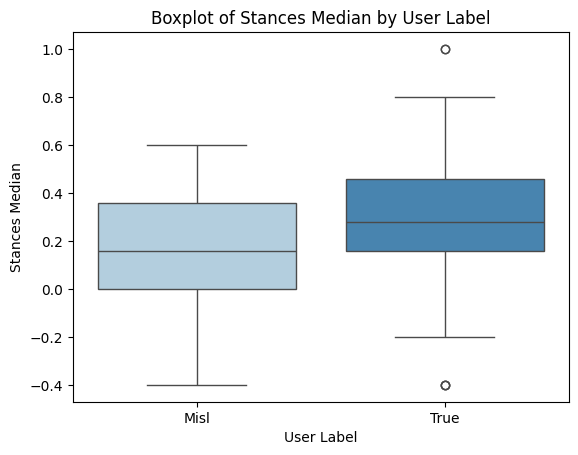

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='Category', y='Stances_Median', palette=seaborn_palette)
plt.title('Boxplot of Stances Median by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Median')

## Stances w/ Positions

### Mean

In [61]:
df['Stances_Pos_Mean'] = df['Features_Pos'].apply(lambda x: transform_stances(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\341998645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_Pos_Mean'] = df['Features_Pos'].apply(lambda x: transform_stances(x, method=np.mean))


In [62]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# df['Stances_Pos_Mean'] = scaler.fit_transform(np.array(df['Stances_Pos_Mean']).reshape(-1, 1)).flatten()

In [63]:
df['Stances_Pos_Mean'].describe()

count    474.000000
mean       0.267910
std        0.213948
min       -0.573667
25%        0.102262
50%        0.258703
75%        0.426371
max        0.799724
Name: Stances_Pos_Mean, dtype: float64

In [64]:
df.groupby('Category')['Stances_Pos_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,74.0,0.163317,0.205070,-0.573667,0.032266,0.115964,0.277727,0.709541
True,400.0,0.287260,0.210154,-0.466945,0.125278,0.282664,0.440172,0.799724


In [65]:
df.groupby('num_valid_articles')['Stances_Pos_Mean'].describe()


,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,18.0,0.176432,0.350889,-0.573667,0.000000,0.218574,0.453511,0.652381
2,39.0,0.327204,0.230004,0.000000,0.084093,0.356013,0.479238,0.799724
3,44.0,0.253892,0.236085,-0.130481,0.087628,0.196444,0.474851,0.722187
4,60.0,0.263629,0.263537,-0.338335,0.059674,0.251298,0.485771,0.708572
5,65.0,0.263306,0.206845,-0.119915,0.115544,0.231454,0.380197,0.684824
6,80.0,0.248406,0.169440,-0.147579,0.124651,0.261341,0.360283,0.693056
7,94.0,0.263072,0.188737,-0.149414,0.119702,0.252543,0.383606,0.659616
8,58.0,0.299295,0.182930,-0.061861,0.120292,0.323401,0.463101,0.789626
9,13.0,0.267406,0.143534,0.009345,0.232137,0.258051,0.317432,0.543368


In [66]:
pg.normality(data=df, dv='Stances_Pos_Mean', group='Category') #not normally distributed
# pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_Pos_Mean'],
#                 y=df.loc[df['Category'] == 'True', 'Stances_Pos_Mean'],
#                 alternative='less')

,W,pval,normal
Category,,,
Misl,0.939260,0.001463,False
True,0.990291,0.009655,False


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\4194977180.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Pos_Mean', palette=seaborn_palette)


Text(0, 0.5, 'Stances Mean')

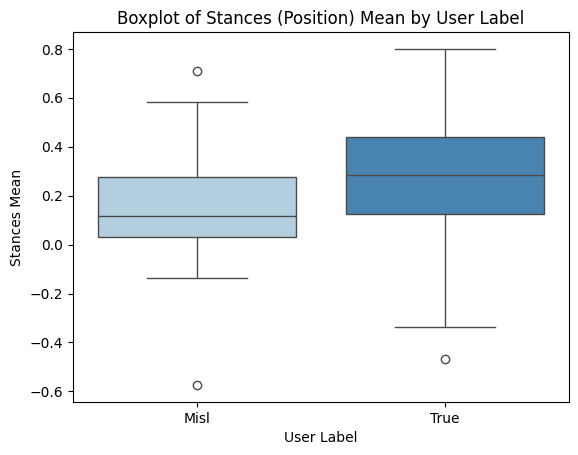

In [67]:
sns.boxplot(data=df, x='Category', y='Stances_Pos_Mean', palette=seaborn_palette)
plt.title('Boxplot of Stances (Position) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

In [68]:
last_search_df = df.drop_duplicates(subset='ResponseId', keep='last')
last_search_df.groupby('Category')['Stances_Pos_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,25.0,0.157323,0.174565,-0.137878,0.053021,0.112573,0.249865,0.571149
True,199.0,0.272927,0.194897,-0.338335,0.136288,0.267708,0.384333,0.799724


## Stances w/ Headlines

### Mean

In [69]:
df['Stances_H_Mean'] = df['Features_H'].apply(lambda x: transform_stances(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\2604616633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_H_Mean'] = df['Features_H'].apply(lambda x: transform_stances(x, method=np.mean))


In [70]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# df['Stances_H_Mean'] = scaler.fit_transform(np.array(df['Stances_H_Mean']).reshape(-1, 1)).flatten()

In [71]:
df['Stances_H_Mean'].describe()

count    474.000000
mean       0.023965
std        0.059201
min       -0.200000
25%        0.000000
50%        0.000000
75%        0.029643
max        0.500000
Name: Stances_H_Mean, dtype: float64

In [72]:
df.groupby('Category')['Stances_H_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,74.0,0.011529,0.064667,-0.057143,0.0,0.0,0.00,0.500000
True,400.0,0.026265,0.057929,-0.200000,0.0,0.0,0.03,0.333333


In [73]:
import pingouin as pg
pg.normality(data=df, dv='Stances_H_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_H_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_H_Mean'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is less than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,10326.0,less,0.000004,-0.302297,0.651149


In [74]:
df.groupby('num_valid_articles')['Stances_H_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,18.0,0.006667,0.079113,-0.200000,0.000,0.000000,0.000000,0.200000
2,39.0,0.038974,0.106519,0.000000,0.000,0.000000,0.000000,0.500000
3,44.0,0.017879,0.070842,-0.013333,0.000,0.000000,0.000000,0.333333
4,60.0,0.026583,0.060887,0.000000,0.000,0.000000,0.002500,0.300000
5,65.0,0.020595,0.053939,-0.080000,0.000,0.000000,0.024000,0.264000
6,80.0,0.025847,0.042865,-0.060000,0.000,0.000000,0.040000,0.160000
7,94.0,0.024051,0.045714,-0.057143,0.000,0.007619,0.034286,0.225714
8,58.0,0.022163,0.047403,-0.025000,0.000,0.012500,0.030000,0.212500
9,13.0,0.025299,0.033915,-0.008889,0.000,0.017778,0.035556,0.088889


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\2672221805.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_H_Mean', palette=seaborn_palette)


Text(0, 0.5, 'Stances Mean')

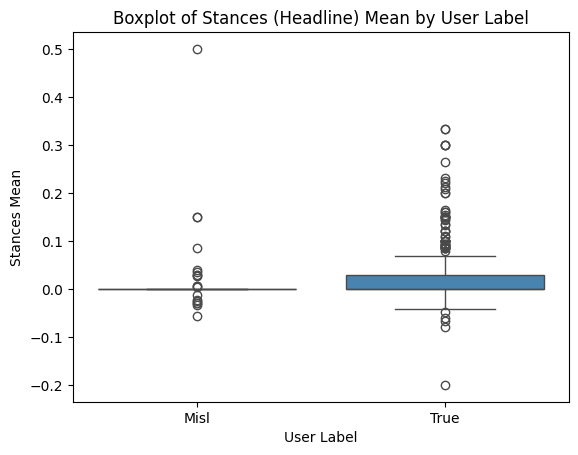

In [75]:
sns.boxplot(data=df, x='Category', y='Stances_H_Mean', palette=seaborn_palette)
plt.title('Boxplot of Stances (Headline) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

## Stances w/ Headlines and Pos

In [76]:
df['Stances_HP_Mean'] = df['Features_HP'].apply(lambda x: transform_stances(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\2275436934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_HP_Mean'] = df['Features_HP'].apply(lambda x: transform_stances(x, method=np.mean))


In [77]:
df['Stances_HP_Mean'].describe()

count    474.000000
mean       0.291855
std        0.235282
min       -0.573667
25%        0.102902
50%        0.283402
75%        0.487264
max        0.980585
Name: Stances_HP_Mean, dtype: float64

In [78]:
df.groupby('Category')['Stances_HP_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,74.0,0.169065,0.216344,-0.573667,0.025632,0.115964,0.302749,0.709541
True,400.0,0.314571,0.231835,-0.466945,0.132698,0.307781,0.503307,0.980585


In [79]:
df.groupby('num_valid_articles')['Stances_HP_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,18.0,0.183875,0.371593,-0.573667,0.000000,0.218574,0.492411,0.717231
2,39.0,0.363138,0.260076,0.000000,0.084093,0.370000,0.552084,0.954245
3,44.0,0.258516,0.240088,-0.142925,0.087628,0.196444,0.518432,0.722187
4,60.0,0.292654,0.290090,-0.338335,0.059674,0.301026,0.550421,0.980585
5,65.0,0.283504,0.230587,-0.243372,0.115544,0.235683,0.509966,0.684824
6,80.0,0.279451,0.191904,-0.179127,0.147942,0.280070,0.395437,0.776891
7,94.0,0.288482,0.212247,-0.237598,0.119970,0.287522,0.455367,0.659616
8,58.0,0.319849,0.199960,-0.061861,0.127571,0.356020,0.503307,0.789626
9,13.0,0.300106,0.168274,-0.002417,0.255385,0.266812,0.423695,0.589088


In [80]:
pg.normality(data=df, dv='Stances_HP_Mean', group='Category') #not normally distributed
# pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_HP_Mean'],
#                 y=df.loc[df['Category'] == 'True', 'Stances_HP_Mean'],
#                 alternative='less')

,W,pval,normal
Category,,,
Misl,0.939336,0.001476,False
True,0.989945,0.007702,False


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\861737964.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_HP_Mean', palette=seaborn_palette)


Text(0, 0.5, 'Stances Mean')

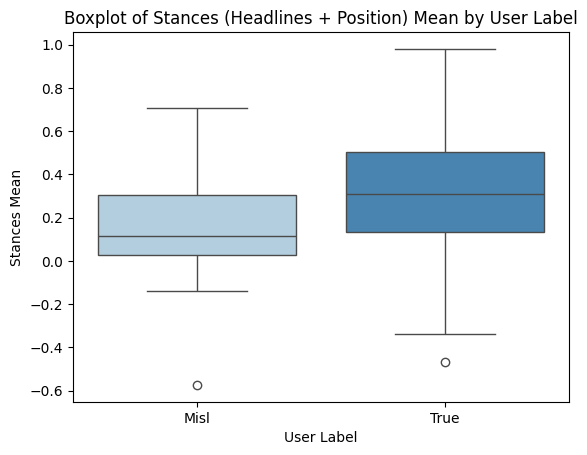

In [81]:
sns.boxplot(data=df, x='Category', y='Stances_HP_Mean', palette=seaborn_palette)
plt.title('Boxplot of Stances (Headlines + Position) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

# Newsguard Score

In [82]:
def transform_newsguard(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    article_ng_scores = feat_dict['article_ng_scores']
    article_ng_scores = np.nan_to_num(article_ng_scores, nan=0)
    return method(article_ng_scores)

In [83]:
df['Newsguard_Mean'] = df['Features_Raw'].apply(lambda x: transform_newsguard(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\1875328657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Newsguard_Mean'] = df['Features_Raw'].apply(lambda x: transform_newsguard(x, method=np.mean))


In [84]:
df.groupby('Category')['avg_score'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,74.0,88.823788,10.605354,35.00,87.784722,91.458333,94.3750,100.0
True,397.0,89.717616,10.152677,21.25,87.750000,91.700000,94.9375,100.0


In [85]:
pg.normality(data=df, dv='avg_score', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
                y=df.loc[df['Category'] == 'True', 'avg_score'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,13780.0,less,0.199002,-0.061883,0.530942


This is the NewsGuard Score of the retrieved articles. For the final calculation, we instead use the average NG score given above.

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\3465771059.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Newsguard_Mean', palette='Set2')


Text(0, 0.5, 'NG Mean')

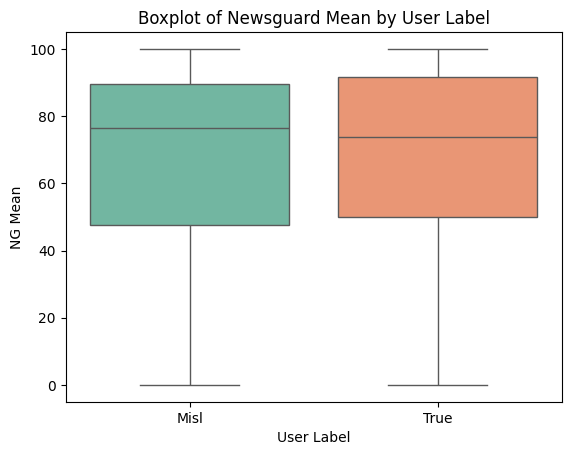

In [86]:
sns.boxplot(data=df, x='Category', y='Newsguard_Mean', palette='Set2')
plt.title('Boxplot of Newsguard Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('NG Mean')

# Article SERP Position

## Mean Rank

In [87]:
def transform_serp_position(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    article_serp_positions = feat_dict['article_serp_positions']
    article_serp_positions = np.nan_to_num(article_serp_positions, nan=0)
    return method(article_serp_positions)

In [88]:
df['SERP_Position_Mean'] = df['Features_Raw'].apply(lambda x: transform_serp_position(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_11368\3830219677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SERP_Position_Mean'] = df['Features_Raw'].apply(lambda x: transform_serp_position(x, method=np.mean))


In [89]:
df.groupby('Category')['SERP_Position_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,74.0,5.467723,1.560043,1.0,4.808333,5.309524,6.25,10.0
True,400.0,5.294329,1.362419,1.0,4.750000,5.285714,6.00,10.0


C:\Users\danie\AppData\Local\Temp\ipykernel_11368\3667827325.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='SERP_Position_Mean', palette='Set3')


Text(0, 0.5, 'NG Mean')

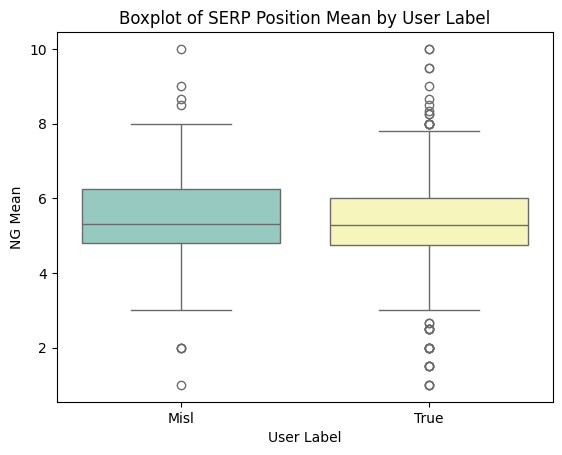

In [90]:
sns.boxplot(data=df, x='Category', y='SERP_Position_Mean', palette='Set3')
plt.title('Boxplot of SERP Position Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('NG Mean')